* 이 강의는 교양을 위한 파인튜닝 강의입니다. 딥러닝에 대해 조금이라도 공부한 고등학생, 대학생이 파라미터를 직접 변경하고 싶을 때 학습해볼 수 있는 내용입니다.

* 강의자료를 만드는데 참고하였던 코드와 영상은 중간중간 링크를 달아두었으니 좀 더 고급 내용을 원한다면 해당 링크를 참고해주세요.

* 읽어볼만한 글: https://medium.com/@hugmanskj/%EA%B1%B0%EB%8C%80-%EC%96%B8%EC%96%B4-%EB%AA%A8%EB%8D%B8-large-language-model-%EC%97%90-%EB%8C%80%ED%95%9C-%EC%9D%B4%ED%95%B4-llm%EC%9D%98-%EA%B8%B0%EC%A4%80%EA%B3%BC-%ED%8A%B9%EC%A7%95%EC%9D%80-%EB%AC%B4%EC%97%87%EC%9D%BC%EA%B9%8C-0551b7b9d3bd

* 글에서 보듯 이러한 모델을 구성하고, 학습을 시키는 일은 이제 일반인에게 거의 불가능에 가깝습니다. 어마어마한 연산 비용과 데이터가 필요합니다. 이러한 가운데 공개된 LLM을 파인튜닝하는 방법은 적절한 대안이 될 수 있습니다.

# 파인튜닝(Fine-tuning)

파인튜닝은 사전 학습된 LLM을 특정 작업이나 도메인에 맞게 추가 학습시키는 과정입니다. 일반적인 LLM 모델에 특정 데이터셋을 추가적으로 학습시킨 다음 대답을 유도하는 형태로 사용하죠. 일반적인 LLM이라기 보다 특수 목적이 있는 LLM을 만들 때, 주로 회사에서 많이 사용합니다.

## 일반 모델 vs 파인튜닝 vs 프롬프트 엔지니어링의 차이

### 1. 일반 모델(Base model) 사용
- 사전 학습된 모델을 그대로 사용
- 광범위한 언어 이해 및 생성 능력 보유
- 특정 도메인에 대한 전문성은 제한적
- 모델 파라미터 변경 없음

### 2. 파인튜닝(Fine-tuning)
- 특정 작업/도메인에 맞춰 모델 파라미터를 추가 학습
- 모델 구조는 그대로 유지하면서 가중치만 조정
- 특정 작업에 대한 성능 향상
- 학습 데이터셋 필요 (수백~수천 개의 예시)
- 계산 비용이 상대적으로 높음
- 모델의 내부 파라미터가 영구적으로 변경됨

### 3. 프롬프트 엔지니어링(Prompt engineering)
- 모델 자체는 변경하지 않고 입력 프롬프트를 조정
- 일회성 사용 방식으로, 모델에 영구적 변화 없음
- 예시(few-shot learning)를 프롬프트에 포함 가능
- 즉시 적용 가능하고 비용 효율적
- 복잡한 작업에 대한 효과는 제한적일 수 있음
- **더 비교해보면 좋을 키워드: 프롬프트 엔지니어링과 RAG**

## 실용적 차이점

1. 일관된 성능과 답변:
   - 파인튜닝 > 프롬프트 엔지니어링 > 일반 모델 (대체로)
   - 파인튜닝은 특히 특화된 작업에서 더 일관된 성능 제공

2. 자원 요구사항:
   - 파인튜닝: 컴퓨팅 자원, 데이터셋, 시간 필요
   - 프롬프트 엔지니어링: 최소한의 자원, 빠른 실험 가능

3. 유지보수:
   - 파인튜닝: 모델 업데이트 시 재학습 필요
   - 프롬프트: 필요에 따라 쉽게 조정 가능

4. 응용:
   - 파인튜닝: 특화된 도메인(의료, 법률 등), 일관된 포맷 필요 시, 폐쇠망에서 GPT와 같은 모델을 사용하고 싶을 때 사용.
   - 프롬프트: 다양한 일반 작업, 빠른 프로토타이핑

In [ ]:
# 해당 노트북은 홍정모 교수님의 강의에 일부 기반합니다.
# 홍정모 교수님과 모델을 개발해주신 카카오에게 감사를 드립니다.

# 대학 수업에서도 가볍게 활용할 수 있도록 설명을 추가하고 colab에서도 간단히 실습할 수 있게 코드를 수정했습니다.
# 4090 기준으로는 4분 정도가 걸리지만 colab에서 실행할경우 대략 25분 정도가(실행할 수 있도록 최적화) 걸립니다.

# 오해: 딥러닝 공부하는데 꼭 4090이 필요한 것은 아니고 2080ti로도 간단한 모델링 공부는 충분히 하실 수 있습니다.
# colab으로는 무리입니다.

# 영상: https://youtu.be/NrDZmSDvXXw

## 모델 준비

In [ ]:
# !pip install transformers>=4.45.0 # 설치를 할 필요는 없습니다. 참고용입니다.
# 링크: https://huggingface.co/kakaocorp/kanana-nano-2.1b-base
# 런타임 > 런타임 유형 변경 v2-8 TPU
# 무료는 최대 12시간, 유료는 최대 24시간동안만 돌아갑니다.

In [ ]:
# 합쳐진 전체 코드는 아래에서 제공합니다. 해당 코드는 이해를 돕기 위한 코드입니다.
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "kakaocorp/kanana-nano-2.1b-base"

In [ ]:
# 사용 가능한 디바이스 확인 및 설정
# CPU도 사용가능하도록 설정
device = "cpu"
print(f"Using device: {device}")

model_name = "kakaocorp/kanana-nano-2.1b-base"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float32,
    trust_remote_code=True,
).to(device)

tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="left")
tokenizer.pad_token = tokenizer.eos_token

Using device: cpu


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/692 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.17G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.9k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

# 데이터셋 준비

customdata.txt로 만드세요.

```
다음 숫자들을 얘기해봐 12345|67890.
이호준이 좋아하는 과일은?|이호준은 바나나를 좋아합니다.
이호준이 자주 가는 여행지는?|이호준은 제주에 살고 있어서 제주 여행지를 자주 갑니다.
이호준 취미는 무엇인가요?|이호준은 악기 연주, 독서와 탁구를 즐깁니다.
이호준이 좋아하는 계절은 무엇인가요?|이호준은 가을을 가장 좋아합니다.
이호준 특기는 무엇인가요?|이호준은 탁구와 악기 연주를 잘 합니다.
이호준이 선호하는 영화 장르는?|이호준은 액션 영화를 선호합니다.
이호준이 좋아하는 운동은?|이호준은 탁구를 좋아합니다.
이호준이 어떤 동물을 좋아하나요?|이호준은 애완동물을 키워본 적이 없습니다.
이호준이 주로 사용하는 소셜 미디어는?|이호준은 페이스북과 유튜브 입니다.
이호준이 좋아하는 음식은?|이호준은 해장국, 국밥류를 아주 좋아합니다.
이호준이 가장 최근에 본 드라마는 무엇인가요?|이호준은 드라마를 보지 않습니다.
```

In [ ]:
# 카나나 모델과 같은 데이터 형식으로 준비 후 학습
qna_list = []
with open("customdata.txt", "r") as file:
    for line in file:
        qna = line.strip().split('|')
        input_str = qna[0] + " " + qna[1]
        item = {'q':qna[0], 'input':input_str, 'q_ids':tokenizer.encode(qna[0]), 'input_ids':tokenizer.encode(input_str)}
        qna_list.append(item)

max_length = max(len(item['input_ids']) for item in qna_list)

for item in qna_list:
    print(f"q: {item['q']}")
    print(f"q_ids: {item['q_ids']}")
    print(f"input: {item['input']}")
    print(f"input_ids: {item['input_ids']}")
    print("-----------")

q: 다음 숫자들을 얘기해봐 12345
q_ids: [128000, 13447, 49531, 70292, 93287, 105880, 123715, 21121, 34983, 122722, 220, 4513, 1774]
input: 다음 숫자들을 얘기해봐 12345 67890.
input_ids: [128000, 13447, 49531, 70292, 93287, 105880, 123715, 21121, 34983, 122722, 220, 4513, 1774, 220, 17458, 1954, 13]
-----------
q: 이호준이 좋아하는 과일은?
q_ids: [128000, 13094, 48424, 102611, 13094, 117004, 44005, 104219, 33177, 34804, 30]
input: 이호준이 좋아하는 과일은? 이호준은 바나나를 좋아합니다.
input_ids: [128000, 13094, 48424, 102611, 13094, 117004, 44005, 104219, 33177, 34804, 30, 23955, 48424, 102611, 34804, 82818, 61415, 61415, 18918, 117004, 61938, 13]
-----------
q: 이호준이 자주 가는 여행지는?
q_ids: [128000, 13094, 48424, 102611, 13094, 65677, 55430, 36609, 16969, 121528, 107054, 30]
input: 이호준이 자주 가는 여행지는? 이호준은 제주에 살고 있어서 제주 여행지를 자주 갑니다.
input_ids: [128000, 13094, 48424, 102611, 13094, 65677, 55430, 36609, 16969, 121528, 107054, 30, 23955, 48424, 102611, 34804, 63171, 55430, 19954, 104657, 35495, 127887, 63171, 55430, 121528, 111010, 65677, 55430, 11740

In [ ]:
qna_list[0]['q']
qna_list[1]['q']
qna_list[2]['q']

'이호준이 자주 가는 여행지는?'

In [ ]:
# 파인튜닝 전에 어떻게 응답하는지 확인

questions = [qna['q'] for qna in qna_list]

input_ids = tokenizer(
    questions,
    padding=True,
    return_tensors="pt",
)["input_ids"].to("cpu")

model.eval()

with torch.no_grad():
    output = model.generate(
        input_ids,
        max_new_tokens=32,
        do_sample=False,
    )

output_list = output.tolist()

for i, output in enumerate(output_list):
    print(f"Q{i}: {tokenizer.decode(output, skip_special_tokens=True)}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Q0: 다음 숫자들을 얘기해봐 12345 123456789 1234567890123456789 123456789012345678901234567890123456789012345678901234567
Q1: 이호준이 좋아하는 과일은??
이호준이 좋아하는 과일은? 이호준이 좋아하는 과일은? 이호준이 좋아하는 과일은? 이
Q2: 이호준이 자주 가는 여행지는? (feat. 이호준의 여행지)
이호준이 자주 가는 여행지는? (feat. 이호준의 여행지) 이
Q3: 이호준 취미는 무엇인가요? 이호준은 취미로 그림을 그리는 것을 좋아합니다. 그는 그림을 그리면서 자신의 감정과 생각을 표현하고, 새로운 아이디어
Q4: 이호준이 좋아하는 계절은 무엇인가요? 이호준은 봄을 좋아합니다. 봄에는 꽃이 피고, 새싹이 돋아나며, 따뜻한
Q5: 이호준 특기는 무엇인가요? 이호준은 2018년 1월 1일부터 2020년 1월 1일까지 2년간 1
Q6: 이호준이 선호하는 영화 장르는? (1) (2) (3) (4) (5) (6) (7) (8) (9) (10) (11
Q7: 이호준이 좋아하는 운동은??
이호준이 좋아하는 운동은? 이호준이 좋아하는 운동은? 이호준이 좋아하는 운동은? 이호준이
Q8: 이호준이 어떤 동물을 좋아하나요? 1. 이호준이 좋아하는 동물은 무엇인가요? 2. 이호준이 좋아하는 동물은 무엇인가요?
Q9: 이호준이 주로 사용하는 소셜 미디어는? 1. 페이스북 2. 인스타그램 3. 트위터 4. 유튜브 5. 블로그 
Q10: 이호준이 좋아하는 음식은??
이호준이 좋아하는 음식은? 이호준이 좋아하는 음식은? 이호준이 좋아하는 음식은? 이
Q11: 이호준이 가장 최근에 본 드라마는 무엇인가요? 이호준이 가장 최근에 본 드라마는 무엇인가요? 이호준이 가장 최근에 본 드라마는 무엇인가요? 이호준이
Q12: 이호준에 대해서 얘기해봐. 이호준은 누구야?
이호준에 대해서 얘기해봐. 이호준은 누구야? 이호준은 대한민국의 배우이자
Q13: 이호준이 좋아하는 운동은??
이호준이 좋아하는 운동은? 이호준이

In [ ]:
# 파인튜닝 전에 어떻게 응답하는지 확인 - 질문 해보고 싶은 것 입력하여 질문

questions = ['이호준은 누구지?'] # 질문 입력하시면 됩니다.

input_ids = tokenizer(
    questions,
    padding=True,
    return_tensors="pt",
)["input_ids"].to("cpu")

model.eval()

with torch.no_grad():
    output = model.generate(
        input_ids,
        max_new_tokens=32,
        do_sample=False,
    )

output_list = output.tolist()

print(output_list) # 디코드를 해주어야 인간의 언어로 대답

for i, output in enumerate(output_list):
    print(f"Q{i}: {tokenizer.decode(output, skip_special_tokens=True)}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[[128000, 13094, 48424, 102611, 34804, 123621, 22035, 30, 23955, 48424, 102611, 34804, 23955, 48424, 102611, 80052, 13, 128001]]
Q0: 이호준은 누구지? 이호준은 이호준입니다.


## 훈련

In [ ]:
# 전체 코드
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from torch.utils.data import Dataset, DataLoader
import gc

# 메모리 정리
torch.cuda.empty_cache()
gc.collect()

# 디바이스 설정
device = torch.device("cpu")
print(f"Using device: {device}")

# 모델 및 토크나이저 로드
model_name = "kakaocorp/kanana-nano-2.1b-base"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float32,
    trust_remote_code=True,
)
tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="left")
tokenizer.pad_token = tokenizer.eos_token
EOT = 128001

# 데이터 로드
qna_list = []
with open("customdata.txt", "r") as file:
    for line in file:
        qna = line.strip().split('|')
        input_str = qna[0] + " " + qna[1]
        item = {'q': qna[0], 'input': input_str, 'q_ids': tokenizer.encode(qna[0]), 'input_ids': tokenizer.encode(input_str)}
        qna_list.append(item)

max_length = max(len(item['input_ids']) for item in qna_list)
print(f"Max length: {max_length}")

# 파인튜닝 전 모델 테스트(필요한 경우 주석 풀고 실행)
# print("Testing model before fine-tuning:")
# questions = [qna['q'] for qna in qna_list]

# model.eval()
# with torch.no_grad():
#     input_ids = tokenizer(
#         questions,
#         padding=True,
#         return_tensors="pt",
#     )["input_ids"].to(device)

#     output = model.generate(
#         input_ids,
#         max_new_tokens=32,
#         do_sample=False,
#     )

# output_list = output.tolist()
# for i, output in enumerate(output_list):
#     print(f"Q{i}: {tokenizer.decode(output, skip_special_tokens=True)}")

# 데이터셋 정의
class MyDataset(Dataset):
    def __init__(self, qna_list, max_length):
        self.input_ids = []
        self.target_ids = []

        for qa in qna_list:
            token_ids = qa['input_ids']
            input_chunk = token_ids
            target_chunk = token_ids[1:]
            input_chunk += [EOT] * (max_length - len(input_chunk))
            target_chunk += [EOT] * (max_length - len(target_chunk))
            len_ignore = len(qa['q_ids']) - 1  # target은 한 글자가 짧기 때문
            target_chunk[:len_ignore] = [-100] * len_ignore

            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

# 데이터셋 및 데이터로더 생성
dataset = MyDataset(qna_list, max_length=max_length)
train_loader = DataLoader(dataset, batch_size=2, shuffle=True, drop_last=False)

# 학습을 위한 파라미터 설정
model.to(device)

# 중요: 파라미터 학습 가능하도록 설정
for param in model.parameters():
    param.requires_grad = True

# 학습 가능한 파라미터 확인
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"Trainable parameters: {trainable_params:,} ({trainable_params/total_params:.2%} of total)")

# 옵티마이저 설정 - 학습 가능한 파라미터만 전달
optimizer = torch.optim.AdamW([p for p in model.parameters() if p.requires_grad],
                             lr=0.00001, weight_decay=0.01)

# 학습 루프
tokens_seen, global_step = 0, -1
losses = []

print("Starting training...")
for epoch in range(3):
    model.train()

    epoch_loss = 0
    for input_batch, target_batch in train_loader:
        gc.collect()

        optimizer.zero_grad()
        input_batch, target_batch = input_batch.to(device), target_batch.to(device)

        logits = model(input_batch).logits

        loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
        epoch_loss += loss.item()
        loss.backward()

        # 그래디언트 클리핑 (선택사항)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        tokens_seen += input_batch.numel()
        global_step += 1

        print(f"Step: {global_step}, Tokens seen: {tokens_seen}, Loss: {loss.item():.4f}")

        # 주기적으로 메모리 정리
        del logits, loss
        gc.collect()

    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch: {epoch}, Average Loss: {avg_loss:.4f}")

    torch.save(model, f"model_{str(epoch).zfill(3)}.pth")

print("Training completed!")

Using device: cpu


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Max length: 32
Trainable parameters: 2,086,979,328 (100.00% of total)
Starting training...
Step: 0, Tokens seen: 64, Loss: 4.0611
Step: 1, Tokens seen: 128, Loss: 5.1196
Step: 2, Tokens seen: 192, Loss: 1.2417
Step: 3, Tokens seen: 256, Loss: 0.6134
Step: 4, Tokens seen: 320, Loss: 1.1184
Step: 5, Tokens seen: 384, Loss: 0.5160
Epoch: 0, Average Loss: 2.1117
Step: 6, Tokens seen: 448, Loss: 0.2639
Step: 7, Tokens seen: 512, Loss: 0.0648
Step: 8, Tokens seen: 576, Loss: 0.1769
Step: 9, Tokens seen: 640, Loss: 0.1668
Step: 10, Tokens seen: 704, Loss: 0.3963
Step: 11, Tokens seen: 768, Loss: 0.1160
Epoch: 1, Average Loss: 0.1974
Step: 12, Tokens seen: 832, Loss: 0.0894
Step: 13, Tokens seen: 896, Loss: 0.1325
Step: 14, Tokens seen: 960, Loss: 0.1962
Step: 15, Tokens seen: 1024, Loss: 0.0899
Step: 16, Tokens seen: 1088, Loss: 0.3981
Step: 17, Tokens seen: 1152, Loss: 0.0137
Epoch: 2, Average Loss: 0.1533
Training completed!


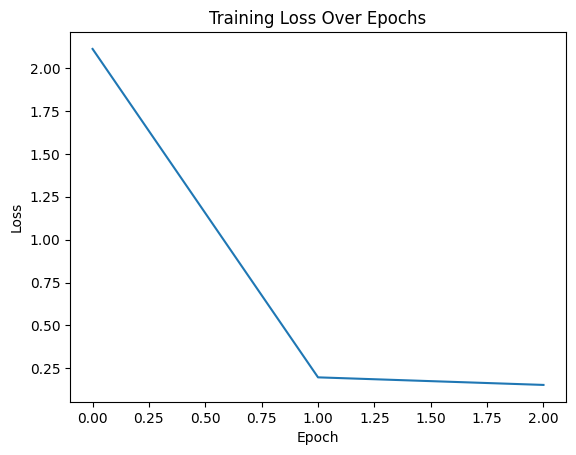

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

In [ ]:
# 파인튜닝 후 모델 테스트
print("Testing model after fine-tuning:")
questions = ['이호준은 누구지?'] # 질문 입력하시면 됩니다.
'''
1. 이호준은 누구이고, 어디에 살고 있지?
2. 이호준 사업을 하고 있는데 어디서 무슨 사업을 하고 있지?
'''
model.eval()
with torch.no_grad():
    input_ids = tokenizer(
        questions,
        padding=True,
        return_tensors="pt",
    )["input_ids"].to(device)

    output = model.generate(
        input_ids,
        max_new_tokens=32,
        do_sample=False,
    )

output_list = output.tolist()
for i, output in enumerate(output_list):
    print(f"Q{i}: {tokenizer.decode(output, skip_special_tokens=True)}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Testing model after fine-tuning:
Q0: 이호준은 누구지? 이호준은 제주에 살고 있어서 제주에 살고 있어서 제주에 살고 있어서 제주에 살고 있어서 제주에 살


In [ ]:
# 과제: 커스텀 데이터에 노래 가사 또는 좋아하는 가수나 연예인, 영화 줄거리 등을 넣고
# 테스트 해보는 시간 가지겠습니다.
# 만약 로컬에서 그래픽 카드를 이용해 돌리는 것이 가능하다면
# 대용량 파일을 PDF로 읽어와서 파인튜닝 해보는 시간을 가져보는 것을 권해드립니다.

허깅페이스 코드 참고한 부분들(홍정모 교수님의 주석을 그대로 가져옴)

- [라마 모델](https://github.com/huggingface/transformers/blob/main/src/transformers/models/llama/modeling_llama.py)
- [대답 생성하는 부분(generate)](https://github.com/huggingface/transformers/blob/main/src/transformers/generation/utils.py#L1906)
- [실제로 모델을 사용하는 부분(forward)](https://github.com/huggingface/transformers/blob/main/src/transformers/generation/utils.py#L2827)
- [훈련(train)](https://github.com/huggingface/transformers/blob/main/src/transformers/trainer.py#L2612)